# Convolutional Gaussian Processes
Mark van der Wilk (July 2019)

Here we show a simple example of the rectangles experiment, where we compare a normal squared exponential GP, and a convolutional GP. This is similar to the experiment in [1].

[1] Van der Wilk, Rasmussen, Hensman (2017). Convolutional Gaussian Processes. *Advances in Neural Information Processing Systems 30*.

## Generate dataset
Generate a simple dataset of rectangles. We want to classify whether they are tall or wide. **NOTE:** Here we take care to make sure that the rectangles don't touch the edge, which is different to the original paper. We do this to avoid needing to use patch weights, which are needed to correctly account for edge effects.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

from gpflow import set_trainable
from gpflow.ci_utils import is_continuous_integration

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")

# for reproducibility of this notebook:
np.random.seed(123)
tf.random.set_seed(42)

MAXITER = 2 if is_continuous_integration() else 100
NUM_TRAIN_DATA = (
    5 if is_continuous_integration() else 100
)  # This is less than in the original rectangles dataset
NUM_TEST_DATA = 7 if is_continuous_integration() else 300
H = W = 14  # width and height. In the original paper this is 28
IMAGE_SHAPE = [H, W]

In [2]:
def make_rectangle(arr, x0, y0, x1, y1):
    arr[y0:y1, x0] = 1
    arr[y0:y1, x1] = 1
    arr[y0, x0:x1] = 1
    arr[y1, x0 : x1 + 1] = 1


def make_random_rectangle(arr):
    x0 = np.random.randint(1, arr.shape[1] - 3)
    y0 = np.random.randint(1, arr.shape[0] - 3)
    x1 = np.random.randint(x0 + 2, arr.shape[1] - 1)
    y1 = np.random.randint(y0 + 2, arr.shape[0] - 1)
    make_rectangle(arr, x0, y0, x1, y1)
    return x0, y0, x1, y1


def make_rectangles_dataset(num, w, h):
    d, Y = np.zeros((num, h, w)), np.zeros((num, 1))
    for i, img in enumerate(d):
        for j in range(1000):  # Finite number of tries
            x0, y0, x1, y1 = make_random_rectangle(img)
            rw, rh = y1 - y0, x1 - x0
            if rw == rh:
                img[:, :] = 0
                continue
            Y[i, 0] = rw > rh
            break
    return (
        d.reshape(num, w * h).astype(gpflow.config.default_float()),
        Y.astype(gpflow.config.default_float()),
    )

In [3]:
X, Y = data = make_rectangles_dataset(NUM_TRAIN_DATA, *IMAGE_SHAPE)
Xt, Yt = test_data = make_rectangles_dataset(NUM_TEST_DATA, *IMAGE_SHAPE)

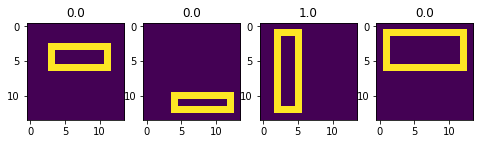

In [4]:
plt.figure(figsize=(8, 3))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(X[i, :].reshape(*IMAGE_SHAPE))
    plt.title(Y[i, 0])

## Squared Exponential kernel

In [5]:
rbf_m = gpflow.models.SVGP(
    gpflow.kernels.SquaredExponential(),
    gpflow.likelihoods.Bernoulli(),
    gpflow.inducing_variables.InducingPoints(X.copy()),
)

In [6]:
rbf_training_loss_closure = rbf_m.training_loss_closure(data, compile=True)
rbf_elbo = lambda: -rbf_training_loss_closure().numpy()
print("RBF elbo before training: %.4e" % rbf_elbo())

RBF elbo before training: -9.9408e+01


In [7]:
set_trainable(rbf_m.inducing_variable, False)
start_time = time.time()
res = gpflow.optimizers.Scipy().minimize(
    rbf_training_loss_closure,
    variables=rbf_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": MAXITER},
)
print(f"{res.nfev / (time.time() - start_time):.3f} iter/s")

34.205 iter/s


In [8]:
train_acc = np.mean((rbf_m.predict_y(X)[0] > 0.5).numpy().astype("float") == Y)
test_acc = np.mean((rbf_m.predict_y(Xt)[0] > 0.5).numpy().astype("float") == Yt)
print(f"Train acc: {train_acc * 100}%\nTest acc : {test_acc*100}%")
print("RBF elbo after training: %.4e" % rbf_elbo())

Train acc: 100.0%
Test acc : 68.33333333333333%
RBF elbo after training: -6.0371e+01


## Convolutional kernel

In [9]:
f64 = lambda x: np.array(x, dtype=np.float64)
positive_with_min = lambda: tfp.bijectors.AffineScalar(shift=f64(1e-4))(tfp.bijectors.Softplus())
constrained = lambda: tfp.bijectors.AffineScalar(shift=f64(1e-4), scale=f64(100.0))(
    tfp.bijectors.Sigmoid()
)
max_abs_1 = lambda: tfp.bijectors.AffineScalar(shift=f64(-2.0), scale=f64(4.0))(
    tfp.bijectors.Sigmoid()
)

patch_shape = [3, 3]
conv_k = gpflow.kernels.Convolutional(gpflow.kernels.SquaredExponential(), IMAGE_SHAPE, patch_shape)
conv_k.base_kernel.lengthscales = gpflow.Parameter(1.0, transform=positive_with_min())
# Weight scale and variance are non-identifiable. We also need to prevent variance from shooting off crazily.
conv_k.base_kernel.variance = gpflow.Parameter(1.0, transform=constrained())
conv_k.weights = gpflow.Parameter(conv_k.weights.numpy(), transform=max_abs_1())
conv_f = gpflow.inducing_variables.InducingPatches(
    np.unique(conv_k.get_patches(X).numpy().reshape(-1, 9), axis=0)
)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


In [10]:
conv_m = gpflow.models.SVGP(conv_k, gpflow.likelihoods.Bernoulli(), conv_f)

In [11]:
set_trainable(conv_m.inducing_variable, False)
set_trainable(conv_m.kernel.base_kernel.variance, False)
set_trainable(conv_m.kernel.weights, False)

In [12]:
conv_training_loss_closure = conv_m.training_loss_closure(data, compile=True)
conv_elbo = lambda: -conv_training_loss_closure().numpy()
print("conv elbo before training: %.4e" % conv_elbo())

conv elbo before training: -8.7271e+01


In [13]:
start_time = time.time()
res = gpflow.optimizers.Scipy().minimize(
    conv_training_loss_closure,
    variables=conv_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": MAXITER / 10},
)
print(f"{res.nfev / (time.time() - start_time):.3f} iter/s")

7.102 iter/s


In [14]:
set_trainable(conv_m.kernel.base_kernel.variance, True)
res = gpflow.optimizers.Scipy().minimize(
    conv_training_loss_closure,
    variables=conv_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": MAXITER},
)
train_acc = np.mean((conv_m.predict_y(X)[0] > 0.5).numpy().astype("float") == Y)
test_acc = np.mean((conv_m.predict_y(Xt)[0] > 0.5).numpy().astype("float") == Yt)
print(f"Train acc: {train_acc * 100}%\nTest acc : {test_acc*100}%")
print("conv elbo after training: %.4e" % conv_elbo())

Train acc: 100.0%
Test acc : 99.0%
conv elbo after training: -2.6753e+01


In [15]:
res = gpflow.optimizers.Scipy().minimize(
    conv_training_loss_closure,
    variables=conv_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": MAXITER},
)
train_acc = np.mean((conv_m.predict_y(X)[0] > 0.5).numpy().astype("float") == Y)
test_acc = np.mean((conv_m.predict_y(Xt)[0] > 0.5).numpy().astype("float") == Yt)
print(f"Train acc: {train_acc * 100}%\nTest acc : {test_acc*100}%")
print("conv elbo after training: %.4e" % conv_elbo())

Train acc: 100.0%
Test acc : 99.0%
conv elbo after training: -2.6736e+01


In [16]:
set_trainable(conv_m.kernel.weights, True)
res = gpflow.optimizers.Scipy().minimize(
    conv_training_loss_closure,
    variables=conv_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": MAXITER},
)
train_acc = np.mean((conv_m.predict_y(X)[0] > 0.5).numpy().astype("float") == Y)
test_acc = np.mean((conv_m.predict_y(Xt)[0] > 0.5).numpy().astype("float") == Yt)
print(f"Train acc: {train_acc * 100}%\nTest acc : {test_acc*100}%")
print("conv elbo after training: %.4e" % conv_elbo())

Train acc: 100.0%
Test acc : 97.66666666666667%
conv elbo after training: -1.7001e+01


In [17]:
gpflow.utilities.print_summary(rbf_m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.566551769311426
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.751291793039125
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(100, 196)",float64,"[[0., 0., 0...."
SVGP.q_mu,Parameter,Identity,,True,"(100, 1)",float64,[[-5.78241751e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 100, 100)",float64,"[[[6.44747990e-01, 0.00000000e+00, 0.00000000e+00..."


In [18]:
gpflow.utilities.print_summary(conv_m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.base_kernel.variance,Parameter,Sigmoid + AffineScalar,,True,(),float64,99.99004154847385
SVGP.kernel.base_kernel.lengthscales,Parameter,Softplus + AffineScalar,,True,(),float64,0.6379395614540211
SVGP.kernel.weights,Parameter,Sigmoid + AffineScalar,,True,"(144,)",float64,"[0.09624324, 0.32541702, 0.50972961..."
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(45, 9)",float64,"[[0., 0., 0...."
SVGP.q_mu,Parameter,Identity,,True,"(45, 1)",float64,[[0.0125055...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 45, 45)",float64,"[[[7.08615702e-02, 0.00000000e+00, 0.00000000e+00..."


## Conclusion
The convolutional kernel performs much better in this simple task. It demonstrates non-local generalization of the strong assumptions in the kernel.